<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Spatial_interpolation/regression_kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Kriging in R

Zia Ahmed, Unversity Buffalo

The regression kriging (RK) combines a simple or multiple regression model with kriging of the regression residuals. Firstly, a regression model is fitted to the data. Then, the regression model is used to predict the target variable at all sampling locations. The residuals of the predictions are obtained for all samples by calculating the difference between observed and predicted values from regression analysis.  An experimental variogram is drawn from the residuals, and the krigged residuals are summed with the regression prediction to obtain spatial predictions of the target variable.

It is particularly useful when you have additional auxiliary variables (covariates) related to the target variable and can provide valuable information for improving predictions. Regression Kriging integrates the strengths of both regression analysis and Kriging to produce more accurate and robust spatial predictions.

Regression Kriging with machine learning (ML) is an advanced geostatistical approach that combines the strengths of ML and Kriging for spatial prediction. This technique leverages of diffrent types of ML algorithms to build the regression component, incorporating auxiliary variables while also utilizing Kriging to capture spatial autocorrelation of residuals of the ML model and make predictions at unsampled locations.

Here's how Regression Kriging works:

**Components of Regression Kriging:**

1. **Target Variable (Z):** This is the variable you want to predict at unsampled locations.

2. **Auxiliary Variables (X1, X2, ...):** These are additional variables, also known as covariates or predictors, that are available at both sampled and unsampled locations. These variables are related to the target variable and can provide additional information for prediction.

**The Regression Kriging Process:**

1. **Regression Modeling:**
   - Use regression analysis to model the relationship between the target variable (Z) and the auxiliary variables (X1, X2, ...). This regression model captures the systematic variation in the target variable explained by the auxiliary variables.

2. **Residual Calculation:**
   - Calculate the residuals by subtracting the observed values from the values predicted by the regression model. Residuals represent the unexplained variation in the target variable after accounting for the auxiliary variables.

3. **Variogram Analysis for Residuals:**
   - Calculate and model the variogram of the residuals. Variogram analysis helps quantify the spatial autocorrelation in the residuals, capturing the spatial dependence that is not explained by the regression model.

4. **Kriging of Residuals:**
   - Apply Kriging to the residuals, using the variogram model determined in the previous step. Kriging estimates the residuals at unsampled locations, incorporating both the spatial autocorrelation and the information from the observed residuals.

5. **Combined Prediction:**
   - Add the predictions from the regression model to the Kriged residuals to obtain the final predictions for the target variable. This step combines the systematic predictions from the regression model with the spatially dependent predictions from Kriging, resulting in more accurate and reliable predictions.

**Advantages of Regression Kriging:**
- **Incorporating Additional Information:** Regression Kriging allows you to incorporate valuable information from auxiliary variables, enhancing the prediction accuracy.
  
- **Handling Spatial Autocorrelation:** By using Kriging on the residuals, Regression Kriging captures and models the spatial autocorrelation in the target variable that is not accounted for by the regression model alone.

- **Improved Predictions:** The combination of regression predictions and Kriged residuals often leads to more accurate and robust predictions, especially in situations where both the systematic trends from regression and the spatial patterns are important.

Regression Kriging is commonly used in fields such as environmental science, agriculture, geology, and remote sensing, where accurate spatial predictions are crucial for decision-making. It is a powerful tool in **Digital Soil Mapping** that enhances prediction accuracy, incorporates auxiliary data, accounts for spatial dependence, reduces model bias, provides prediction uncertainty, and produces spatially continuous maps. It is invaluable for a wide range of applications where understanding and managing soil properties are essential.


In this exerciser we will use following models for regression kriging of SOC:

- Generalized Linear Model with h2o

- Random Forest with h2o

- Extreme Gradient Boosting with h2o

- Stack Ensemble model with tidymodel framework

- AutoML with h20



### Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314933 sha256=32608d2dabe1d664f4ed7d73ece21d1af91ce872032306773cfc0656ece582ad
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table', 'gstat','Hmisc','corrplot',
         'ggmap','ggpmisc', 'plyr','spatstat','dismo','fields', 'moments', 'car')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (tidyverse)
library (tidymodels)
library (terra)
library (tidyterra)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(classInt)
library(plyr)
library(spatstat)
library(dismo)
library(fields)
library(moments)
library(car)
library(ggpmisc)

### Data

The following data will be used in the exercise that can be found in my [Dropbox](https://www.dropbox.com/scl/fo/j7322sbo4gdqv8a2rfqry/h?rlkey=fmlnsu08lut4pxf0s4q1jm44a&dl=0) folder.

1. GP_all_data.csv

2. GP_prediction_grid_data.csv



In [16]:
%%R
mf<-read_csv('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/GP_all_data.csv')
grid<-read_csv('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/GP_prediction_grid_data.csv')


Rows: 471 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10674 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): x, y, Aspect, ELEV, FRG, K_Factor, MAP, MAT, NDVI, NLCD, Silt_Clay...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Data Transformation

First, we have to calculate appropriate transformation parameters using the **powerTransform()** function of the car package and then use this parameter to transform the data using the **bcPower()** function.

In [50]:
%%R
power<-powerTransform(mf$SOC)
lambda<-power$lambda
lambda

   mf$SOC 
0.2905371 


In [51]:
%%R
mf$SOC.bc<-bcPower(mf$SOC,lambda)

### Convert to factor

In [52]:
%%R
mf$NLCD <- as.factor(mf$NLCD)
mf$FRG <- as.factor(mf$FRG)

grid$NLCD <- as.factor(grid$NLCD)
grid$FRG <- as.factor(grid$FRG)

In [53]:
%%R
# Split data
set.seed(1245)   # for reproducibility
split <- initial_split(mf, prop = 0.8, strata = SOC.bc)
train <- split %>% training()
test <-  split %>% testing()

In [20]:
%%R
train.df<-train %>% dplyr::select(SOC.bc, ELEV, Slope, Aspect, TPI, K_Factor, Silt_Clay, MAT, MAP,NDVI, NLCD, FRG)
test.df<-test %>% dplyr::select(SOC.bc, ELEV, Slope, Aspect, TPI, K_Factor, Silt_Clay, MAT, MAP,NDVI, NLCD, FRG)
grid.df<-grid %>% dplyr::select(ELEV, Slope, Aspect, TPI, K_Factor, Silt_Clay, MAT, MAP,NDVI, NLCD, FRG)

In [210]:
%%R
df.xy<-mf %>% dplyr::select(x, y, SOC, SOC.bc)
train.xy<-train %>% dplyr::select(x, y, SOC, SOC.bc)
test.xy<-test %>% dplyr::select(x, y, SOC, SOC.bc)
grid.xy<-grid %>% dplyr::select(x,y)

In [211]:
%%R
coordinates(test.xy)<-~x+y

### Map training and test data

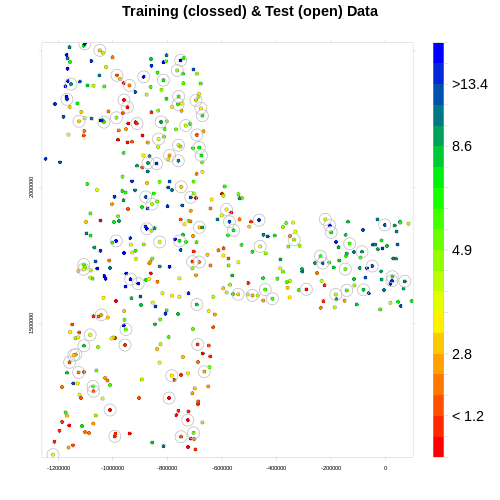

In [56]:
%%R -w 500 -h 500 -u px

at = classIntervals(df.xy$SOC, n = 20, style = "quantile")$brks
round(quantile(df.xy$SOC, probs=seq(0,1, by=0.05)),1)
rgb.palette.col <- colorRampPalette(c("red","yellow", "green", "blue"),space = "rgb")

levelplot(SOC~x+y, df.xy,cex=0.6,
              aspect = "iso",main= "Training (clossed) & Test (open) Data",
              xlab="", ylab="",
              scales=list(y=list(draw=T,cex=0.5,rot=90, tck= 0.5),x=list(draw=T, cex=0.5,tck= 0.6)),
              par.settings=list(axis.line=list(col="grey",lwd=0.5)),
              col.regions=rgb.palette.col (20),at=at,
              colorkey=list(space="right",width=1.2,at=1:21,labels=list(cex=1.2,at=1:21,
              labels=c("","","< 1.2","" ,"","2.8","","","","","4.9","","","","","8.6","","",">13.4","",""))),
              panel = function(...) {
              panel.levelplot.points(...)
              sp.points(test.xy, col="grey", cex=2, pch=21)
              #sp.polygons(bound,lty=1,lwd=0.5,col="grey30")
              },)

###  Scale the covariates

In [57]:
%%R
# Scale data
train.df[-c(1,11,12)] = scale(train.df[-c(1,11,12)])
test.df[-c(1,11,12)] = scale(test.df[-c(1,11,12)])
grid.df[-c(10,11)] = scale(grid.df[-c(10,11)])

###  **Import h2o**



In [58]:
%%R
.libPaths('drive/My Drive/R')
library(h2o)
h2o.init()
#disable progress bar for RMarkdown
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         11 minutes 43 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.42.0.2 
    H2O cluster version age:    2 months and 29 days 
    H2O cluster name:           H2O_started_from_R_root_qtu738 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.16 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.3.1 (2023-06-16) 



### Import data to h2o server

In [59]:
%%R
h_train = as.h2o(train.df)
h_test = as.h2o(test.df)
h_grid = as.h2o(grid.df)

### Define response and predictors

In [60]:
%%R
y <- "SOC.bc"
x <- setdiff(names(h_train), y)

## **Generalized Linear Model (GLM) with H2O**

A generalized linear model (GLM) is a statistical framework that extends the traditional linear regression model to accommodate a broader range of response variables and model assumptions. The GLM allows for the response variable to follow a distribution other than the normal distribution, and allows for the relationship between the response variable and the predictor variables to be modeled using a nonlinear function.

First will fit the GLM model with a comprehensive environmental co-variate, Then, we will compute and model the variogram of the of residuals of the GLM model and then simple kriging (SK) will be applied to the residuals to estimate the spatial prediction of the residuals (regional trend). Finally, GLM regression predicted results, and the SK kriged residuals will be added to estimate the interpolated soil organic C.

The h2o package provides an open-source implementation of GLM that is specifically designed for big data. To use the GLM function in h2o, you will need to first install and load the package in your R environment. Once the package is loaded, you can use the h2o.glm() function to fit a GLM model.

### Fit GLM model with grid search

In [61]:
%%R
# hyper parameters
GLM_hyper_params <-list(
             alpha = c(0,0.25,0.5,0.75,1),
             lambda = c(1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0))

# Grid search
GLM_grid <- h2o.grid(
                  algorithm="glm",
                  grid_id = "GLM_grid_IDs",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  stopping_metric = "RMSE",
                  nfolds=10,
                  keep_cross_validation_predictions = TRUE,
                  hyper_params = GLM_hyper_params,
                  seed = 42)

### The best GLM model

In [62]:
%%R
GLM_get_grid <- h2o.getGrid("GLM_grid_IDs",sort_by="RMSE",decreasing=FALSE)
best_GLM <- h2o.getModel(GLM_get_grid@model_ids[[1]])
best_GLM


Model Details:

H2ORegressionModel: glm
Model ID:  GLM_grid_IDs_model_12 
GLM Model: summary
    family     link                            regularization
1 gaussian identity Elastic Net (alpha = 0.25, lambda = 0.1 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                         19                           7                    1
       training_frame
1 train.df_sid_aa3b_7

Coefficients: glm coefficients
       names coefficients standardized_coefficients
1  Intercept     2.074524                  2.074524
2      FRG.1     0.000000                  0.000000
3    FRG.133     0.000000                  0.000000
4      FRG.2     0.000000                  0.000000
5      FRG.3     0.000000                  0.000000
6      FRG.4     0.000000                  0.000000
7      FRG.5     0.000000                  0.000000
8     NLCD.4     0.000000                  0.000000
9     NLCD.5    -0.128269                 -0.128269
10    NLCD.6     0.000000      

### Model performance

In [63]:
%%R
# train performance
# h2o.performance(best_GLM, h_train)
# test performance
h2o.performance(best_GLM, h_test)

H2ORegressionMetrics: glm

MSE:  0.9248885
RMSE:  0.9617112
MAE:  0.7663344
RMSLE:  0.5708056
Mean Residual Deviance :  0.9248885
R^2 :  0.5602322
Null Deviance :202.0147
Null D.o.F. :95
Residual Deviance :88.7893
Residual D.o.F. :88
AIC :282.9403



### Variogram modeling of GLM residuals

In [212]:
%%R
pred.glm.train<-as.data.frame(h2o.predict(object = best_GLM, newdata = h_train))
train.xy$glm_predict<-pred.glm.train$predict
train.xy$glm_residuals<-(train.xy$SOC.bc- train.xy$glm_predict)

In [213]:
%%R
coordinates(train.xy) = ~x+y
#coordinates(test.xy) = ~x+y
coordinates(grid.xy) = ~x+y

In [214]:
%%R
# Variogram of residuals
v.glm<-variogram(glm_residuals~ 1, data = train.xy,cutoff=200000, width=200000/15)
# Intial parameter set by eye esitmation
m.glm<-vgm(0.15,"Exp",40000,0.05)
# least square fit
m.f.glm<-fit.variogram(v.glm, m.glm)
m.f.glm

  model     psill    range
1   Nug 0.4138080     0.00
2   Exp 0.6014218 27941.43


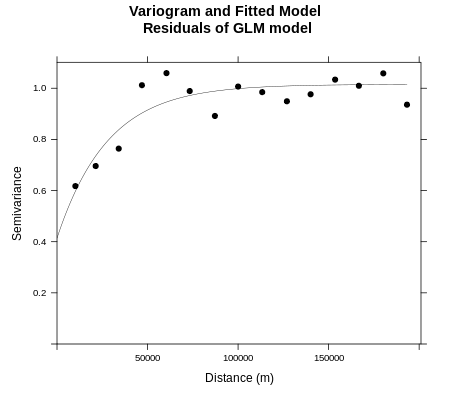

In [215]:
%%R -w 450 -h 400 -u px
plot(v.glm, pl=F,
     model=m.f.glm,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Variogram and Fitted Model\n Residuals of GLM model",
     xlab="Distance (m)",
     ylab="Semivariance")

###  **Kriging prediction of GLM residuals at grid locations**





In [216]:
%%R
SK.GLM.grid<-krige(glm_residuals~ 1,
              loc=train.xy,        # Data frame
              newdata=grid.xy,     # Prediction location
              model = m.f.glm,     # fitted varigram model
              beta = 0)            # Simple kriging
summary(SK.GLM.grid)

[using simple kriging]
Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
   var1.pred           var1.var     
 Min.   :-1.94695   Min.   :0.6153  
 1st Qu.:-0.12753   1st Qu.:0.8637  
 Median : 0.02611   Median :0.9239  
 Mean   : 0.01016   Mean   :0.9091  
 3rd Qu.: 0.16615   3rd Qu.:0.9680  
 Max.   : 1.52497   Max.   :1.0142  


### **GLM prediction of at grid locations**

In [217]:
%%R
pred.glm.grid<-as.data.frame(h2o.predict(object = best_GLM, newdata = h_grid))
grid.xy$GLM<-pred.glm.grid$predict

### **Regression Kriging prediction (Kriging prediction of residuals + GLM prediction)**

In [218]:
%%R
grid.xy$SK_GLM_residuals<-SK.GLM.grid$var1.pred
#  GLM predicted + krige predicted residuals
grid.xy$RK_GLM_BC<-(grid.xy$GLM+grid.xy$SK_GLM_residuals)
head(as.data.frame(grid.xy))


       GLM SK_GLM_residuals RK_GLM_BC        x       y
1 3.680790       0.06434061  3.745131 -1185285 2533795
2 3.817747       0.05693885  3.874686 -1175285 2533795
3 3.973172       0.03829614  4.011468 -1165285 2533795
4 3.481607       0.01025789  3.491865 -1155285 2533795
5 2.740987      -0.02511376  2.715873 -1145285 2533795
6 2.841201      -0.06851074  2.772691 -1135285 2533795


### Back-transformation

In [219]:
%%R
k<-1/lambda
grid.xy$RK_GLM_SOC <-((grid.xy$RK_GLM_BC *lambda +1)^k)
summary(grid.xy)

Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
      GLM           SK_GLM_residuals     RK_GLM_BC        RK_GLM_SOC     
 Min.   :-0.02861   Min.   :-1.94695   Min.   :-1.109   Min.   : 0.2621  
 1st Qu.: 1.37556   1st Qu.:-0.12753   1st Qu.: 1.325   1st Qu.: 3.0683  
 Median : 1.91599   Median : 0.02611   Median : 1.948   Median : 4.6821  
 Mean   : 2.03105   Mean   : 0.01016   Mean   : 2.041   Mean   : 5.6413  
 3rd Qu.: 2.65492   3rd Qu.: 0.16615   3rd Qu.: 2.741   3rd Qu.: 7.5099  
 Max.   : 4.49697   Max.   : 1.52497   Max.   : 5.332   Max.   :25.0486  


### Plot Maps

In [220]:
%%R
# Convert to raster
GLM<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "GLM")])
SK.GLM.RES<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "SK_GLM_residuals")])
RK.GLM.BC<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "RK_GLM_BC")])
RK.GLM.SOC<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "RK_GLM_SOC")])

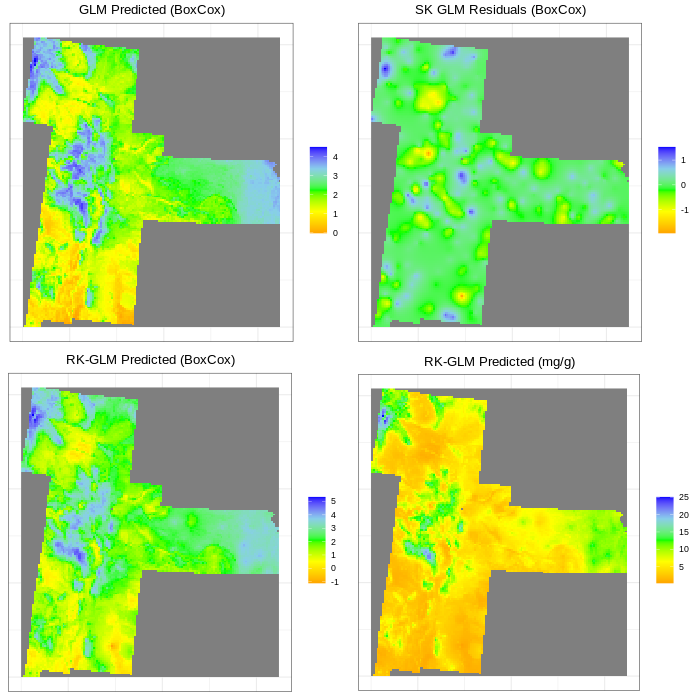

In [221]:
%%R -w 700 -h 700 -u px
glm1<-ggR(GLM, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("GLM Predicted (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

glm2<-ggR(SK.GLM.RES, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("SK GLM Residuals (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

glm3<-ggR(RK.GLM.BC, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("RK-GLM Predicted (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

glm4<-ggR(RK.GLM.SOC, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("RK-GLM Predicted (mg/g)")+
   theme(plot.title = element_text(hjust = 0.5))

grid.arrange(glm1,glm2,glm3,glm4, ncol = 2, nrow=2)  # Multiplot

## **GLM-RK Validation with an test data set**

In [222]:
%%R
# kriging prediction at test
SK.GLM.test<-krige(glm_residuals~ 1,
              loc=train.xy,        # Data frame
              newdata=test.xy,     # Prediction location
              model = m.f.glm,     # fitted varigram model
              beta = 0)
#

[using simple kriging]


In [223]:
%%R
# GLM predition at test location
pred.glm.test<-as.data.frame(h2o.predict(object = best_GLM, newdata = h_test))
test.xy$GLM<-pred.glm.test$predict

In [226]:
%%R
# GLM predicted + krige predicted residuals
test.xy$SK_GLM_residuals<-SK.GLM.test$var1.pred
test.xy$RK_GLM_BC<-(test.xy$GLM+test.xy$SK_GLM_residuals)
head(as.data.frame(test.xy))

           x       y   SOC     SOC.bc       GLM SK_GLM_residuals RK_GLM_BC
1 -1106344.8 1716869 5.995  2.3493848 2.9561298     -0.295413234 2.6607166
2 -1106102.3 1419122 7.596  2.7616589 2.6500335      0.008310051 2.6583436
3 -1107341.6 1699359 3.782  1.6238976 2.7913933     -0.438599922 2.3527934
4  -758470.9 2333273 6.500  2.4870774 1.5620617      0.137033086 1.6990948
5  -793772.4 1227380 0.471 -0.6762409 0.9644404     -0.179797693 0.7846427
6  -823011.5 2239871 9.451  3.1682421 1.7482600     -0.137331721 1.6109282


In [227]:
%%R
diff.glm<-(test.xy$SOC.bc-test.xy$RK_GLM_BC)
# Mean Error (ME)
GLM.ME<-round(mean(diff.glm),3)
# Mean Absolute Error
GLM.MAE<-round(mean(abs(diff.glm)),3)
# Root Mean Squre Error (RMSE)
GLM.RMSE<-round(sqrt(mean(diff.glm^2)),3)
GLM.RMSE

[1] 0.948


`geom_smooth()` using formula = 'y ~ x'


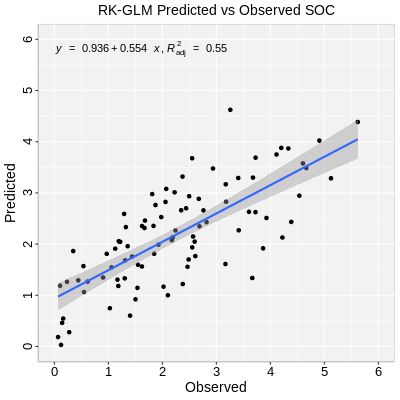

In [229]:
%%R -w 400 -h 400 -u px

test.df<-as.data.frame(test.xy)

formula<-y~x

ggplot(test.df, aes(SOC.bc,RK_GLM_BC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("RK-GLM Predicted vs Observed SOC") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Random Forest**


Random Forest (RF) is a tree-based machine learning algorithm used for classification, regression, and other tasks in data analysis. It is a popular and robust algorithm that builds multiple decision trees and combines their predictions to make a final prediction. RF is a modification of Bagging (bootstrap aggregating) regression trees that builds a large collection of de-correlated trees and has become a very popular "out-of-the-box" learning algorithm that has low variance and higher predictive power than traditional bagging models.

Each decision tree in the Random Forest is constructed by randomly selecting a subset of the available features and then building a tree based on those features. This process is repeated a specified number of times, resulting in multiple decision trees. When a new data point needs to be classified, each tree in the forest is used to make a prediction, and the final prediction is based on the most common prediction made by all the trees.

### **Random Forest with hyperparameter tuning  with H20**

RF in h20 is also referred to as a distributed random forest (DRF), which is a parallel implementation of Random Forest. In a DRF, individual trees are trained on a subset of the data rows and columns. This randomization helps to minimize overfitting and enhance model accuracy and stability. The individual tree predictions are then combined to form a final prediction.

DRF also offers a range of hyperparameter values that can be adjusted to improve the model's performance, the number of trees, the depth of the trees, and the sampling rate for each tree. The algorithm can also be used to automatically fine-tune hyperparameters using either grid or random search. Overall, DRF in H2O provides a powerful and scalable tool for building accurate and robust predictive models on large datasets by distributing the computation across a cluster of machines, DRF can handle datasets that would be too large to process on a single machine, making it a valuable tool for big data applications.

H2O Grid Search is a hyperparameter optimization technique used in the H2O machine learning framework. It involves a systematic search through a specified subset of hyperparameters of a machine learning model to find the optimal combination of hyperparameters that maximizes the performance metric of interest, such as RMSE or AUC.

* ntrees : number of trees

* mtries: number of variables randomly sampled as candidates at each split.

* max_depth: Maximum tree depth (0 for unlimited). Defaults to 20.

* min_rows: Fewest allowed (weighted) observations in a leaf.

* sample_rate: Row sample rate per tree (from 0.0 to 1.0) Defaults to 0.632.

In [83]:
%%R
# Hyperparameter
RF_hyper_params <- list(
  ntrees      = seq(10, 500, by = 20),
  mtries      = seq(10, 40, by = 10),
  max_depth   = seq(20, 40, by = 5),
  min_rows    = seq(1, 5, by = 1),
  sample_rate = c(0.5, 0.6, 0.7, 0.8, 0.9))
# Search criteria
RF_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 100,
                        max_runtime_secs = 900,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 42)
RF_hyper_params

$ntrees
 [1]  10  30  50  70  90 110 130 150 170 190 210 230 250 270 290 310 330 350 370
[20] 390 410 430 450 470 490

$mtries
[1] 10 20 30 40

$max_depth
[1] 20 25 30 35 40

$min_rows
[1] 1 2 3 4 5

$sample_rate
[1] 0.5 0.6 0.7 0.8 0.9



### **Fit DRF model with Grid Search**

In [84]:
%%R
rf_grid <- h2o.grid(
                  algorithm="randomForest",
                  grid_id = "RF_grid_IDs",
                  x = x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  stopping_metric = "RMSE",
                  #fold_assignment ="Stratified",
                  nfolds=10,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = RF_hyper_params,
                  search_criteria = RF_search_criteria,
                  seed = 42)


### The best DRF model

In [85]:
%%R
DRF_get_grid <- h2o.getGrid("RF_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)
# Get the best RF model
best_DRF <- h2o.getModel(DRF_get_grid@model_ids[[1]])
best_DRF

Model Details:

H2ORegressionModel: drf
Model ID:  RF_grid_IDs_model_48 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              70                       70               50046         8
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        16   10.97143         45         59    52.25714


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  1.031514
RMSE:  1.015635
MAE:  0.7592572
RMSLE:  NaN
Mean Residual Deviance :  1.031514



H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  1.05691
RMSE:  1.028061
MAE:  0.7655773
RMSLE:  NaN
Mean Residual Deviance :  1.05691


Cross-Validation Metrics Summary: 
                           mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                    0.758141 0.134938   0.799023   0.991447   0.

### Model Performance

In [86]:
%%R
# train performance
# h2o.performance(best_DRF, h_train)
# test performance
h2o.performance(best_DRF, h_test)

H2ORegressionMetrics: drf

MSE:  0.983598
RMSE:  0.9917651
MAE:  0.8167939
RMSLE:  0.5428869
Mean Residual Deviance :  0.983598



### **Variogram modeling of DRF residuals**

In [230]:
%%R
pred.rf.train<-as.data.frame(h2o.predict(object = best_DRF, newdata = h_train))
train.xy$rf_predict<-pred.rf.train$predict
train.xy$rf_residuals<-(train.xy$SOC.bc- train.xy$rf_predict)

In [231]:
%%R
# Variogram of RF residuals
v.rf<-variogram(rf_residuals~ 1, data = train.xy,cutoff=400000, width=400000/15)
# Intial parameter set by eye esitmation
m.rf<-vgm(0.15,"Exp",40000,0.05)
# least square fit
m.f.rf<-fit.variogram(v.rf, m.rf)
m.f.rf

  model     psill    range
1   Nug 0.0000000     0.00
2   Exp 0.4290982 10194.38


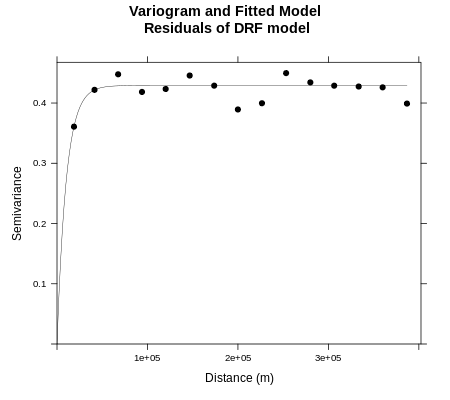

In [232]:
%%R -w 450 -h 400 -u px
plot(v.rf, pl=F,
     model=m.f.rf,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Variogram and Fitted Model\n Residuals of DRF model",
     xlab="Distance (m)",
     ylab="Semivariance")

### **Kriging prediction of DRF residuals at grid locations**

In [233]:
%%R
SK.DRF.grid<-krige(rf_residuals~ 1,
              loc=train.xy,        # Data frame
              newdata=grid.xy,     # Prediction location
              model = m.f.rf,     # fitted varigram model
              beta = 0)            # Simple kriging
summary(SK.DRF.grid)


[using simple kriging]
Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
   var1.pred             var1.var       
 Min.   :-2.1404651   Min.   :0.005658  
 1st Qu.:-0.0270665   1st Qu.:0.407575  
 Median : 0.0001843   Median :0.425007  
 Mean   :-0.0012217   Mean   :0.406029  
 3rd Qu.: 0.0279169   3rd Qu.:0.428567  
 Max.   : 1.5445224   Max.   :0.429098  


### **DRF prediction of at grid locations**

In [234]:
%%R
pred.rf.grid<-as.data.frame(h2o.predict(object = best_DRF, newdata = h_grid))
grid.xy$DRF<-pred.rf.grid$predict

### **Regression Kriging prediction (Kriging prediction of residuals + DRF prediction)**

In [235]:
%%R
grid.xy$SK_DRF_residuals<-SK.DRF.grid$var1.pred
#  DRF predicted + krige predicted residuals
grid.xy$RK_DRF_BC<-(grid.xy$DRF+grid.xy$SK_DRF_residuals)
head(as.data.frame(grid.xy))

       GLM SK_GLM_residuals RK_GLM_BC RK_GLM_SOC      DRF SK_DRF_residuals
1 3.680790       0.06434061  3.745131  12.605268 3.946199     -0.004584377
2 3.817747       0.05693885  3.874686  13.404713 3.819925     -0.015891987
3 3.973172       0.03829614  4.011468  14.287115 3.277041     -0.032248486
4 3.481607       0.01025789  3.491865  11.141045 2.984734     -0.038422862
5 2.740987      -0.02511376  2.715873   7.404771 2.875913     -0.029541950
6 2.841201      -0.06851074  2.772691   7.642593 2.866549     -0.023120746
  RK_DRF_BC        x       y
1  3.941615 -1185285 2533795
2  3.804033 -1175285 2533795
3  3.244792 -1165285 2533795
4  2.946311 -1155285 2533795
5  2.846371 -1145285 2533795
6  2.843429 -1135285 2533795


### Back-transformation

In [236]:
%%R
k<-1/lambda
grid.xy$RK_DRF_SOC <-((grid.xy$RK_DRF_BC *lambda +1)^k)
summary(grid.xy)

Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
      GLM           SK_GLM_residuals     RK_GLM_BC        RK_GLM_SOC     
 Min.   :-0.02861   Min.   :-1.94695   Min.   :-1.109   Min.   : 0.2621  
 1st Qu.: 1.37556   1st Qu.:-0.12753   1st Qu.: 1.325   1st Qu.: 3.0683  
 Median : 1.91599   Median : 0.02611   Median : 1.948   Median : 4.6821  
 Mean   : 2.03105   Mean   : 0.01016   Mean   : 2.041   Mean   : 5.6413  
 3rd Qu.: 2.65492   3rd Qu.: 0.16615   3rd Qu.: 2.741   3rd Qu.: 7.5099  
 Max.   : 4.49697   Max.   : 1.52497   Max.   : 5.332   Max.   :25.0486  
      DRF          SK_DRF_residuals       RK_DRF_BC        RK_DRF_SOC      
 Min.   :-0.4733   Min.   :-2.1404651   Min.   :-1.963   Min.   : 0.05458  
 1st Qu.: 1.3892   1st Qu.:-0.0270665   1st Qu.: 1.367   1st Qu.: 3.16237  
 Median : 2.0287   Median : 0.0001843   Median : 2.020   Median : 4

### **Plot Maps**

In [237]:
%%R
# Convert to raster
DRF<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "DRF")])
SK.DRF.RES<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "SK_DRF_residuals")])
RK.DRF.BC<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "RK_DRF_BC")])
RK.DRF.SOC<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "RK_DRF_SOC")])

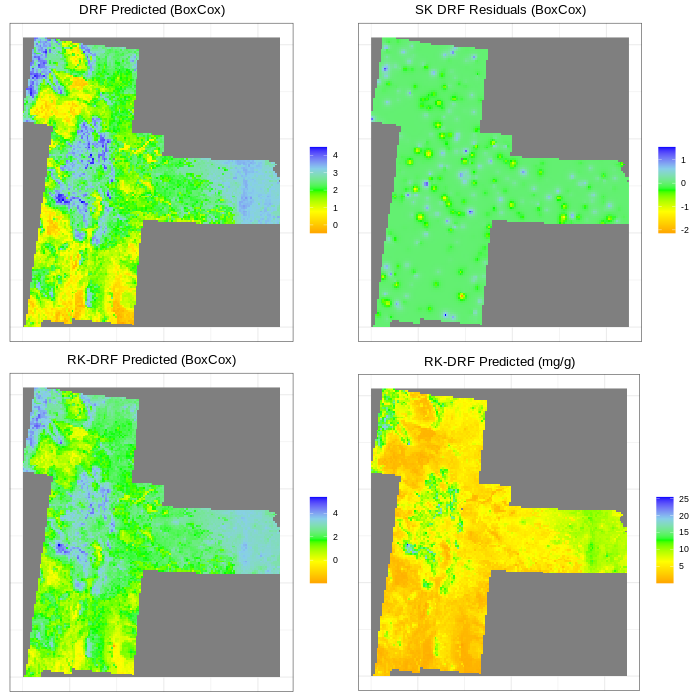

In [238]:
%%R -w 700 -h 700 -u px
rf1<-ggR(DRF, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("DRF Predicted (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

rf2<-ggR(SK.DRF.RES, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("SK DRF Residuals (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

rf3<-ggR(RK.DRF.BC, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("RK-DRF Predicted (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

rf4<-ggR(RK.DRF.SOC, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("RK-DRF Predicted (mg/g)")+
   theme(plot.title = element_text(hjust = 0.5))

grid.arrange(rf1, rf2, rf3, rf4, ncol = 2, nrow=2)  # Multiplot

### **RK-DRF Validation with an test data set**

In [239]:
%%R
# kriging prediction at test
SK.DRF.test<-krige(rf_residuals~ 1,
              loc=train.xy,        # Data frame
              newdata=test.xy,     # Prediction location
              model = m.f.rf,     # fitted varigram model
              beta = 0)

[using simple kriging]


In [242]:
%%R
# DRF predition at test location
pred.rf.test<-as.data.frame(h2o.predict(object = best_DRF, newdata = h_test))
test.xy$DRF<-pred.rf.test$predict

### Residuals

In [244]:
%%R
# DRF predicted + krige predicted residuals
test.xy$SK_DRF_residual<-SK.DRF.test$var1.pred
test.xy$RK_DRF_BC<-(test.xy$DRF+test.xy$SK_DRF_residual)
head(as.data.frame(test.xy))

           x       y   SOC     SOC.bc       GLM SK_GLM_residuals RK_GLM_BC
1 -1106344.8 1716869 5.995  2.3493848 2.9561298     -0.295413234 2.6607166
2 -1106102.3 1419122 7.596  2.7616589 2.6500335      0.008310051 2.6583436
3 -1107341.6 1699359 3.782  1.6238976 2.7913933     -0.438599922 2.3527934
4  -758470.9 2333273 6.500  2.4870774 1.5620617      0.137033086 1.6990948
5  -793772.4 1227380 0.471 -0.6762409 0.9644404     -0.179797693 0.7846427
6  -823011.5 2239871 9.451  3.1682421 1.7482600     -0.137331721 1.6109282
       DRF SK_DRF_residual RK_DRF_BC
1 3.579305   -0.0235509068  3.555754
2 2.180999   -0.0004770426  2.180522
3 2.585480   -0.0942935023  2.491186
4 1.903482    0.0053140650  1.908796
5 1.185618   -0.0022980922  1.183320
6 1.964577   -0.0606378537  1.903939


### Model Performance

In [249]:
%%R
diff.drf<-test.xy$SOC.bc-test.xy$RK_DRF_BC
# Mean Error (ME)
ME.DRF<-round(mean(diff.drf),3)
# Mean Absolute Error
MAE.DRF<-round(mean(abs(diff.drf)),3)
# Root Mean Squre Error (RMSE)
RMSE.DRF<-round(sqrt(mean(diff.drf^2)),3)
RMSE.DRF

[1] 0.994


`geom_smooth()` using formula = 'y ~ x'


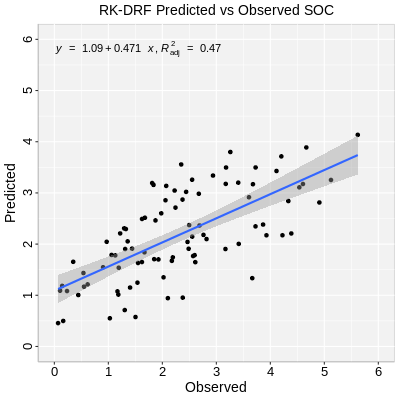

In [251]:
%%R -w 400 -h 400 -u px

test.df<-as.data.frame(test.xy)

formula<-y~x

ggplot(test.df, aes(SOC.bc,RK_DRF_BC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("RK-DRF Predicted vs Observed SOC") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Extreme Gradient Boosting (XGBoost)**

XGBoost (eXtreme Gradient Boosting) is a popular open-source machine learning library that is used to build gradient boosting models. It was first introduced in 2016 and has since become one of the most widely used and highly regarded machine learning algorithms for structured data.

The XGBoost algorithm works by building a series of decision trees, where each subsequent tree tries to correct the errors of the previous tree. The algorithm also employs a gradient-based optimization approach to find the optimal set of parameters for each decision

### **XGBoost with hyperparameter tunning in h20**

Create a grid of hyperparameters to search over during hyperparameter tuning. You can specify different values for hyperparameters such as ntrees, max_depth, learn_rate, min_rows,  sample_rate, etc.

### Hyper prameters and Search Criteria

In [252]:
%%R
# hyper parameters
XGB_hyper_params = list( ntrees = seq(50,500,50),
                     max_depth = seq(1,120,1),
                     min_rows = c(1,5,10,20,50,100),
                     learn_rate = seq(0.001,0.01,0.001),
                     sample_rate = seq(0.3,1,0.05),
                     col_sample_rate = seq(0.3,1,0.05),
                     col_sample_rate_per_tree = seq(0.3,1,0.05))

# Search Criteria
XGB_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 100,
                        max_runtime_secs = 900,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 1345767)

### Grid-search

In [253]:
%%R
XGBoost_grid <- h2o.grid(
                  algorithm="xgboost",
                  grid_id = "XGB_grid_ID",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  stopping_metric = "rmse",
                  #fold_assignment ="Stratified",
                  nfolds=10,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = XGB_hyper_params,
                  search_criteria = XGB_search_criteria,
                  booster = "dart",
                  normalize_type = "tree",
                  seed = 42)

### The best XGBoost model

In [254]:
%%R
XGB_get_grid <- h2o.getGrid("XGB_grid_ID",sort_by="rmse",decreasing=FALSE)
best_XGB <- h2o.getModel(XGB_get_grid@model_ids[[1]])
best_XGB


Model Details:

H2ORegressionModel: xgboost
Model ID:  XGB_grid_ID_model_13 
Model Summary: 
  number_of_trees
1             258


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.880704
RMSE:  0.9384583
MAE:  0.728602
RMSLE:  NaN
Mean Residual Deviance :  0.880704



H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  1.010548
RMSE:  1.00526
MAE:  0.7644535
RMSLE:  NaN
Mean Residual Deviance :  1.010548


Cross-Validation Metrics Summary: 
                           mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                    0.758546 0.130381   0.803056   0.970976   0.827331
mean_residual_deviance 0.990724 0.332093   1.110227   1.570396   1.014701
mse                    0.990724 0.332093   1.110227   1.570396   1.014701
r2                     0.438093 0.209294   0.534324  -0.077699   0.386347
residual_deviance      0.990724 0.33

### XGBoost model performance

In [255]:
%%R
h2o.performance(best_XGB, h_train)
h2o.performance(best_XGB, newdata =h_test)

H2ORegressionMetrics: xgboost

MSE:  1.201601
RMSE:  1.096175
MAE:  0.8561368
RMSLE:  0.5533938
Mean Residual Deviance :  1.201601



### **Variogram modeling of XGBoost residuals**

In [256]:
%%R
pred.xgb.train<-as.data.frame(h2o.predict(object = best_XGB, newdata = h_train))
train.xy$xgb_predict<-pred.xgb.train$predict
train.xy$xgb_residuals<-(train.xy$SOC.bc- train.xy$xgb_predict)

In [257]:
%%R
# Variogram of XGBoost residuals
v.xgb<-variogram(xgb_residuals~ 1, data = train.xy,cutoff=400000, width=400000/15)
# Intial parameter set by eye esitmation
m.xgb<-vgm(0.15,"Exp",40000,0.05)
# least square fit
m.f.xgb<-fit.variogram(v.xgb, m.xgb)
m.f.xgb

  model     psill    range
1   Nug 0.2994372     0.00
2   Exp 0.4656444 20862.22


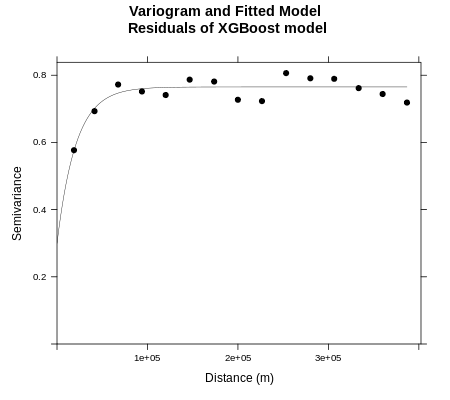

In [258]:
%%R -w 450 -h 400 -u px
plot(v.xgb, pl=F,
     model=m.f.xgb,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Variogram and Fitted Model\n Residuals of XGBoost model",
     xlab="Distance (m)",
     ylab="Semivariance")

### **Kriging prediction of DRF residuals at grid locations**

In [259]:
%%R
SK.XGB.grid<-krige(xgb_residuals~ 1,
              loc=train.xy,        # Data frame
              newdata=grid.xy,     # Prediction location
              model = m.f.xgb,     # fitted varigram model
              beta = 0)            # Simple kriging
summary(SK.XGBoost.grid)

[using simple kriging]
Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
   var1.pred           var1.var       
 Min.   :-2.50526   Min.   :0.006698  
 1st Qu.:-0.02215   1st Qu.:0.548588  
 Median : 0.01188   Median :0.584845  
 Mean   : 0.02910   Mean   :0.553805  
 3rd Qu.: 0.08120   3rd Qu.:0.594678  
 Max.   : 1.73425   Max.   :0.596836  


### **XGBoost prediction of at grid locations**

In [260]:
%%R
pred.xgb.grid<-as.data.frame(h2o.predict(object = best_XGB, newdata = h_grid))
grid.xy$XGB<-pred.xgb.grid$predict

### **Regression Kriging prediction (Kriging prediction of residuals + XGBoost prediction)**

In [261]:
%%R
grid.xy$SK_XGB_residuals<-SK.XGB.grid$var1.pred
#  XGBoost predicted + krige predicted residuals
grid.xy$RK_XGB_BC<-(grid.xy$XGB+grid.xy$SK_XGB_residuals)
head(as.data.frame(grid.xy))

       GLM SK_GLM_residuals RK_GLM_BC RK_GLM_SOC      DRF SK_DRF_residuals
1 3.680790       0.06434061  3.745131  12.605268 3.946199     -0.004584377
2 3.817747       0.05693885  3.874686  13.404713 3.819925     -0.015891987
3 3.973172       0.03829614  4.011468  14.287115 3.277041     -0.032248486
4 3.481607       0.01025789  3.491865  11.141045 2.984734     -0.038422862
5 2.740987      -0.02511376  2.715873   7.404771 2.875913     -0.029541950
6 2.841201      -0.06851074  2.772691   7.642593 2.866549     -0.023120746
  RK_DRF_BC RK_DRF_SOC      XGB SK_XGB_residuals RK_XGB_BC        x       y
1  3.941615  13.831497 2.888847       0.10999465  2.998841 -1185285 2533795
2  3.804033  12.964416 2.786719       0.12593990  2.912659 -1175285 2533795
3  3.244792   9.833069 2.545577       0.13193869  2.677516 -1165285 2533795
4  2.946311   8.402896 2.443370       0.12425453  2.567624 -1155285 2533795
5  2.846371   7.959008 2.337248       0.10525882  2.442507 -1145285 2533795
6  2.843429   7.946

### Back trasformation

In [262]:
%%R
k<-1/lambda
grid.xy$RK_XGB_SOC<-((grid.xy$RK_XGB_BC *lambda +1)^k)
summary(grid.xy)

Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
      GLM           SK_GLM_residuals     RK_GLM_BC        RK_GLM_SOC     
 Min.   :-0.02861   Min.   :-1.94695   Min.   :-1.109   Min.   : 0.2621  
 1st Qu.: 1.37556   1st Qu.:-0.12753   1st Qu.: 1.325   1st Qu.: 3.0683  
 Median : 1.91599   Median : 0.02611   Median : 1.948   Median : 4.6821  
 Mean   : 2.03105   Mean   : 0.01016   Mean   : 2.041   Mean   : 5.6413  
 3rd Qu.: 2.65492   3rd Qu.: 0.16615   3rd Qu.: 2.741   3rd Qu.: 7.5099  
 Max.   : 4.49697   Max.   : 1.52497   Max.   : 5.332   Max.   :25.0486  
      DRF          SK_DRF_residuals       RK_DRF_BC        RK_DRF_SOC      
 Min.   :-0.4733   Min.   :-2.1404651   Min.   :-1.963   Min.   : 0.05458  
 1st Qu.: 1.3892   1st Qu.:-0.0270665   1st Qu.: 1.367   1st Qu.: 3.16237  
 Median : 2.0287   Median : 0.0001843   Median : 2.020   Median : 4

### Convert to raster

In [263]:
%%R
# Convert to raster
XGB<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "XGB")])
SK.XGB.RES<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "SK_XGB_residuals")])
RK.XGB.BC<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "RK_XGB_BC")])
RK.XGB.SOC<-rasterFromXYZ(as.data.frame(grid.xy)[, c("x", "y", "RK_XGB_SOC")])

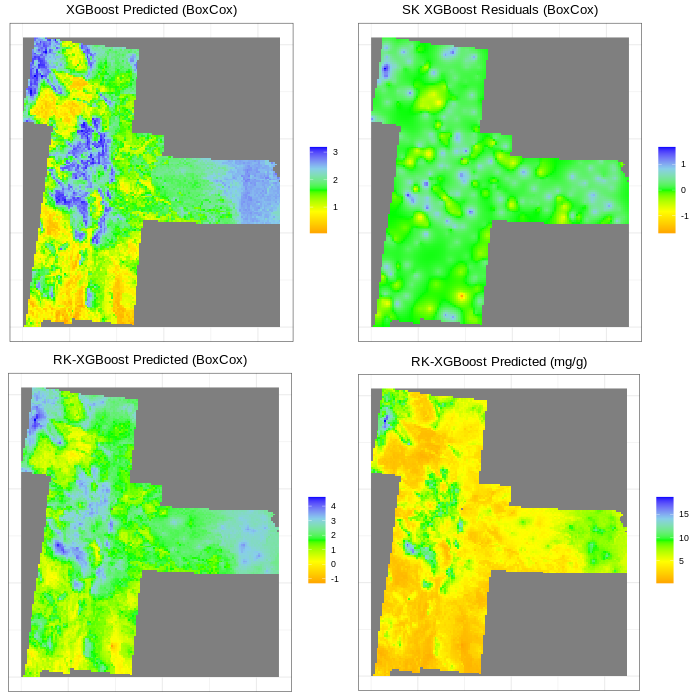

In [265]:
%%R -w 700 -h 700 -u px
xgb1<-ggR(XGB, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("XGBoost Predicted (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

xgb2<-ggR(SK.XGB.RES, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("SK XGBoost Residuals (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

xgb3<-ggR(RK.XGB.BC, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("RK-XGBoost Predicted (BoxCox)")+
   theme(plot.title = element_text(hjust = 0.5))

xgb4<-ggR(RK.XGB.SOC, geom_raster = TRUE) +
  scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("RK-XGBoost Predicted (mg/g)")+
   theme(plot.title = element_text(hjust = 0.5))

grid.arrange(xgb1, xgb2, xgb3, xgb4, ncol = 2, nrow=2)  # Multiplot

### **RK-XGBoost Validation with an test data set**

In [266]:
%%R
# kriging prediction at test
SK.XGB.test<-krige(xgb_residuals~ 1,
              loc=train.xy,        # Data frame
              newdata=test.xy,     # Prediction location
              model = m.f.xgb,     # fitted varigram model
              beta = 0)


[using simple kriging]


In [268]:
%%R
# XGM predition at test location
pred.xgb.test<-as.data.frame(h2o.predict(object = best_XGB, newdata = h_test))
test.xy$XGB<-pred.xgb.test$predict

### Residuals

In [271]:
%%R
# XGBoost predicted + krige predicted residuals
test.xy$SK_XGB_residual<-SK.XGB.test$var1.pred
test.xy$RK_XGB_BC<-(test.xy$XGB+test.xy$SK_XGB_residual)
head(as.data.frame(test.xy))

           x       y   SOC     SOC.bc       GLM SK_GLM_residuals RK_GLM_BC
1 -1106344.8 1716869 5.995  2.3493848 2.9561298     -0.295413234 2.6607166
2 -1106102.3 1419122 7.596  2.7616589 2.6500335      0.008310051 2.6583436
3 -1107341.6 1699359 3.782  1.6238976 2.7913933     -0.438599922 2.3527934
4  -758470.9 2333273 6.500  2.4870774 1.5620617      0.137033086 1.6990948
5  -793772.4 1227380 0.471 -0.6762409 0.9644404     -0.179797693 0.7846427
6  -823011.5 2239871 9.451  3.1682421 1.7482600     -0.137331721 1.6109282
       DRF SK_DRF_residual RK_DRF_BC      XGB SK_XGB_residual RK_XGM_BC
1 3.579305   -0.0235509068  3.555754 2.586303      0.06045473 2.6467577
2 2.180999   -0.0004770426  2.180522 1.970272      0.04369464 2.0139662
3 2.585480   -0.0942935023  2.491186 2.150424     -0.02365448 2.1267698
4 1.903482    0.0053140650  1.908796 1.557708      0.11494437 1.6726523
5 1.185618   -0.0022980922  1.183320 1.031627     -0.05892294 0.9727044
6 1.964577   -0.0606378537  1.903939 1.7724

In [272]:
%%R
diff.xgb<-test.xy$SOC.bc-test.xy$RK_XGB_BC
# Mean Error (ME)
ME.XGB<-round(mean(diff.xgb),3)
# Mean Absolute Error
MAE.XGB<-round(mean(abs(diff.xgb)),3)
# Root Mean Squre Error (RMSE)
RMSE.XGB<-round(sqrt(mean(diff.xgb^2)),3)
RMSE.XGB

[1] 1.015


`geom_smooth()` using formula = 'y ~ x'


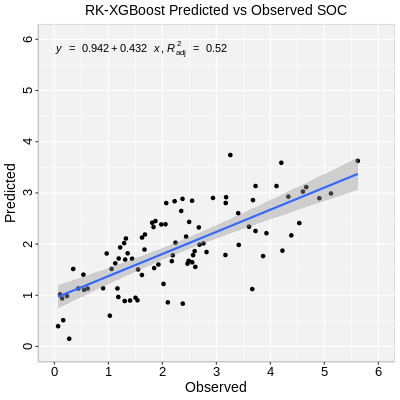

In [273]:
%%R -w 400 -h 400 -u px

test.df<-as.data.frame(test.xy)

formula<-y~x

ggplot(test.df, aes(SOC.bc,RK_XGB_BC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("RK-XGBoost Predicted vs Observed SOC") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Regresion Kriging (RK) with Automatic Machine Learning (AutoML)**

To make machine learning software easier for non-professionals to use, H2O’s AutoML has a user-friendly interface that automatically trains a large number of candidate models. It can also be useful for advanced users by providing a wrapper function that does a lot of modeling-related work that would normally take many lines of code, freeing up time for other data science pipeline activities such as data-processing, feature engineering, and model deployment.

H2O's AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. The interface is designed with minimal parameters so that all you need to do is to point to your dataset, define the response column and optionally set a timeout or limit for the total number of models trained.

In [274]:
%%R
df.aml <- h2o.automl(
                  x= x,
                  y = y,
                  training_frame = h_train,
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  stopping_metric = "RMSE",
                  stopping_tolerance = 0.001,
                  stopping_rounds = 3,
                  max_runtime_secs_per_model = 1,
                  seed = 42,
                  max_models = 100,
                  project_name = "AutoML_trainings")
df.aml


00:27:08.641: Stopping tolerance set by the user is < 70% of the recommended default of 0.05, so models may take a long time to converge or may not converge at all.AutoML Details
Project Name: AutoML_trainings 
Leader Model ID: StackedEnsemble_BestOfFamily_1_AutoML_1_20231025_02708 
Algorithm: stackedensemble 

Total Number of Models Trained: 102 
Start Time: 2023-10-25 00:27:09 UTC 
End Time: 2023-10-25 00:30:14 UTC 
Duration: 185 s

Leaderboard
                                                 model_id     rmse      mse
1  StackedEnsemble_BestOfFamily_1_AutoML_1_20231025_02708 1.003487 1.006985
2                           DRF_1_AutoML_1_20231025_02708 1.007449 1.014953
3                           XRT_1_AutoML_1_20231025_02708 1.008144 1.016354
4     StackedEnsemble_AllModels_1_AutoML_1_20231025_02708 1.012021 1.024187
5                           GLM_1_AutoML_1_20231025_02708 1.012926 1.026020
6             GBM_grid_1_AutoML_1_20231025_02708_model_21 1.013863 1.027917
7             GB

### Leaderboard

In [275]:
%%R
lb <- h2o.get_leaderboard(object = df.aml, extra_columns = "ALL")
head(lb)

                                                model_id     rmse      mse
1 StackedEnsemble_BestOfFamily_1_AutoML_1_20231025_02708 1.003487 1.006985
2                          DRF_1_AutoML_1_20231025_02708 1.007449 1.014953
3                          XRT_1_AutoML_1_20231025_02708 1.008144 1.016354
4    StackedEnsemble_AllModels_1_AutoML_1_20231025_02708 1.012021 1.024187
5                          GLM_1_AutoML_1_20231025_02708 1.012926 1.026020
6            GBM_grid_1_AutoML_1_20231025_02708_model_21 1.013863 1.027917
        mae rmsle mean_residual_deviance training_time_ms
1 0.7639102   NaN               1.006985             1309
2 0.7655029   NaN               1.014953              303
3 0.7637098   NaN               1.016354              569
4 0.7818823   NaN               1.024187             3469
5 0.7791648   NaN               1.026020               11
6 0.7799883   NaN               1.027917               70
  predict_time_per_row_ms            algo
1                0.088755 S

### The best model

In [277]:
%%R
best_ML<- h2o.get_best_model(df.aml, criterion = "RMSE" )
best_ML

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_1_AutoML_1_20231025_02708 
Model Summary for Stacked Ensemble: 
                                         key            value
1                          Stacking strategy cross_validation
2       Number of base models (used / total)              6/6
3           # GBM base models (used / total)              1/1
4       # XGBoost base models (used / total)              1/1
5           # DRF base models (used / total)              2/2
6           # GLM base models (used / total)              1/1
7  # DeepLearning base models (used / total)              1/1
8                      Metalearner algorithm              GLM
9         Metalearner fold assignment scheme           Random
10                        Metalearner nfolds                5
11                   Metalearner fold_column               NA
12        Custom metalearner hyperparameters             None


H2ORegressionMetrics: stackedensembl

### Further Reading

1. [Introduction to kriging](https://dickbrus.github.io/SpatialSamplingwithR/Introkriging.html)

2. [Regression Kriging](https://rpubs.com/leydetd/geostatistics2)

3. [Regression Kriging (RK) Kriging with an External Drift (KED)](https://www.css.cornell.edu/faculty/dgr2/_static/files/R_PDF/CoKrigeR.pdf)